# 0-Dimensional 1-species example

- Introduce equations used in the model

- Go through the whole processes of runing the model and visualization


## For more documentation
- <https://zhenwu0728.github.io/PlanktonIndividuals.jl/dev/> for PlanktonIndividuals.jl
- <http://docs.juliaplots.org/latest/> for Plots.jl
- <https://docs.julialang.org/en/v1/> for Julia

![skematic](PI_Quota.jpeg)

## Photosynthesis

Basically, we follow Geider et al. 1998 for the parameterization of photosynthesis, but without nutrient limitation.


$PP=PP_{max}\cdot (1-e^{\frac{-\alpha \cdot I\cdot Chl}{PP_{max}\cdot C}})$

**Unit: mmolC/cell/s**

$PP_{max}$ is scaled by a power-law relationship of cell size

## Nutrient Uptake

Include intracellular nutrient limitation:

$RegQ_i=\bigg[\frac{R_{iC}^{max}-Q_i}{R_{iC}^{max}-R_{iC}^{min}}\bigg]_0^1$

$V_i=V_i^{max}\cdot regQ_i\cdot\frac{[i]}{[i]+K_i^{sat}}$

$i$ denotes $NH_4$, $NO_3$, $PO_4$.

**Unit: mmolN/cell/s**



### Metabolic Partitioning
$\beta=\frac{a\cdot Vol_{cell}^b}{1+a\cdot Vol_{cell}^b}$

$BioSynC = \beta\cdot k_{mtb}\cdot Q_C^R$

$MaintenC=(1-\beta)\cdot k_{mtb}\cdot Q_C^R$

$BioSynN = k_{mtb}\cdot Q_N^R/R_{NC}$

$BioSynP = k_{mtb}\cdot Q_P^R/R_{PC}$

### Compute biosynthesis rate and excretion rate
$BioSyn=min(BioSynC,BioSynN,BioSynP)$

$ExcretC=BioSynC - BioSyn$

## 1. Import Software, i.e. `Julia` Packages

In [1]:
using PlanktonIndividuals, Oceananigans, YAML, KernelDensity, DelimitedFiles, Plots

## 2. Initialize the model
1. Initialize model grid
2. read parameters (Stored in `params.yml`)
3. Initialize nutrient field
4. Initialize individuals
5. User-defined diagnostics

In [2]:
Nx = 25       # Number of grid points in x and y
Nz = 50       # Number of grid points in z
Δz = 4.0      # Grid spacing in x, y, z (meters)
grid = RegularCartesianGrid(size=(1,1,1), extent=(Δz*Nx, Δz*Nx, Δz*Nz))

RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}
                   domain: x ∈ [0.0, 100.0], y ∈ [0.0, 100.0], z ∈ [-200.0, 200.0]
                 topology: (Periodic, Periodic, Bounded)
  resolution (Nx, Ny, Nz): (1, 1, 1)
   halo size (Hx, Hy, Hz): (1, 1, 1)
grid spacing (Δx, Δy, Δz): (100.0, 100.0, 200.0)

In [14]:
resultpath = PrepRunDir()
phy_grid = read_Ogrids(grid);
nday = 2
RunParam.nTime = 1440*nday # simulated days in minute
RunParam.ΔT = 60 # model time step: 60 seconds

# update paramters
phy_params = YAML.load(open("params.yml"))
update_params!(RunParam.params,phy_params)

Nsp = 1
RunParam.params["P_Nsp"] = Nsp

# Initial conditions
#           DIC  NH4   NO3   PO4   DOC  DON  DOP  POC  PON  POP  ZOO
nut_init = [2.0, 0.05, 0.10, 0.02, 1.0, 0.1, 0.1, 1.0, 0.1, 0.1, 2.0];
phy_model = PI_Model(phy_grid, RunParam;
                     nutrients = setup_nutrients(phy_grid,nut_init));

# User-defined size distribution diagnostics
size_dens = zeros(45,RunParam.nTime,phy_model.params["P_Nsp"])
xInd = collect(0.8:0.05:3.0);

## 3. Run the model
- `PI_TimeStep!` updates the model at each time step
- with user-defined diagnostics

In [15]:
for i in 1:RunParam.nTime
    PI_TimeStep!(phy_model, RunParam.ΔT, resultpath)
    phyts_sp = sort_species(phy_model.individuals.phytos, phy_model.params["P_Nsp"])
    write_species_dynamics(phy_model.t, phyts_sp, resultpath)

    for j in 1:size(phyts_sp,1)
        phyts = phyts_sp[j]
        ksd =kde(phyts[4,:])
        iksd = InterpKDE(ksd)
        size_dens[:,i,j] = pdf(iksd,xInd)
    end
    # write_output(phyts_sp, resultpath, phy_model.t)
end

In [16]:
# post-processing model results
include("post_process.jl")
c = [:red,:blue]
titles = ["Population (10^{14} cell)", "Division (per day)", "Average Cell Size", "Grazing (per day)", "Generation",
          "Biomass (fgC/cell)", "C Reserve (fgC/cell)", "N Reserve (fgN/cell)", "P Reserve (fgP/cell)", "Average Age (hour)"]
tcks = collect(0:86400:86400*nday);
lbs = ["0","1","2","3","4","5","6","7","8","9","10"]
labels = ["Species 1","Species 2"];

## 4. Visualization using `Plots.jl`

In [20]:
p=[]
for i in 1:10
    if i>8
        pt = plot(xlabel="Time (day)",title=titles[i])
    else
        pt = plot(title=titles[i])
    end
    push!(p,pt)
end
plt = plot(p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10],layout = (5,2),size=(1000,1000))
for i in 1:Nsp
    plot!(p[1],collect(1:60:86400*nday),rawdata[:,2,i] ./ 1e3,label=labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :best)
    plot!(p[2],collect(1:3600:86400*nday),pops[:,i,1] ./ pops[:,i,2] .* 24,label=labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[3],collect(1:60:86400*nday),rawdata[:,5,i],label=labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[4],collect(1:3600:86400*nday),pops[:,1,3] ./ pops[:,1,2] .* 24,label =labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[5],collect(1:60:86400*nday),rawdata[:,3,i],label =labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[6],collect(1:60:86400*nday),rawdata[:,6,i] ./ 1e11 .* 12 .*1e12,label =labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[7],collect(1:60:86400*nday),rawdata[:,7,i] ./ 1e11 .* 12 .*1e12,label =labels[i],color=c[i], 
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[8],collect(1:60:86400*nday),rawdata[:,8,i] ./ 1e11 .* 14 .*1e12,label =labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[9],collect(1:60:86400*nday),rawdata[:,9,i] ./ 1e11 .* 31 .*1e12,label =labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
    plot!(p[10],collect(1:60:86400*nday),rawdata[:,4,i],label =labels[i],color=c[i],
        xticks=([1:3600*24:86400*3;],lbs[1:3]),legend = :none)
end

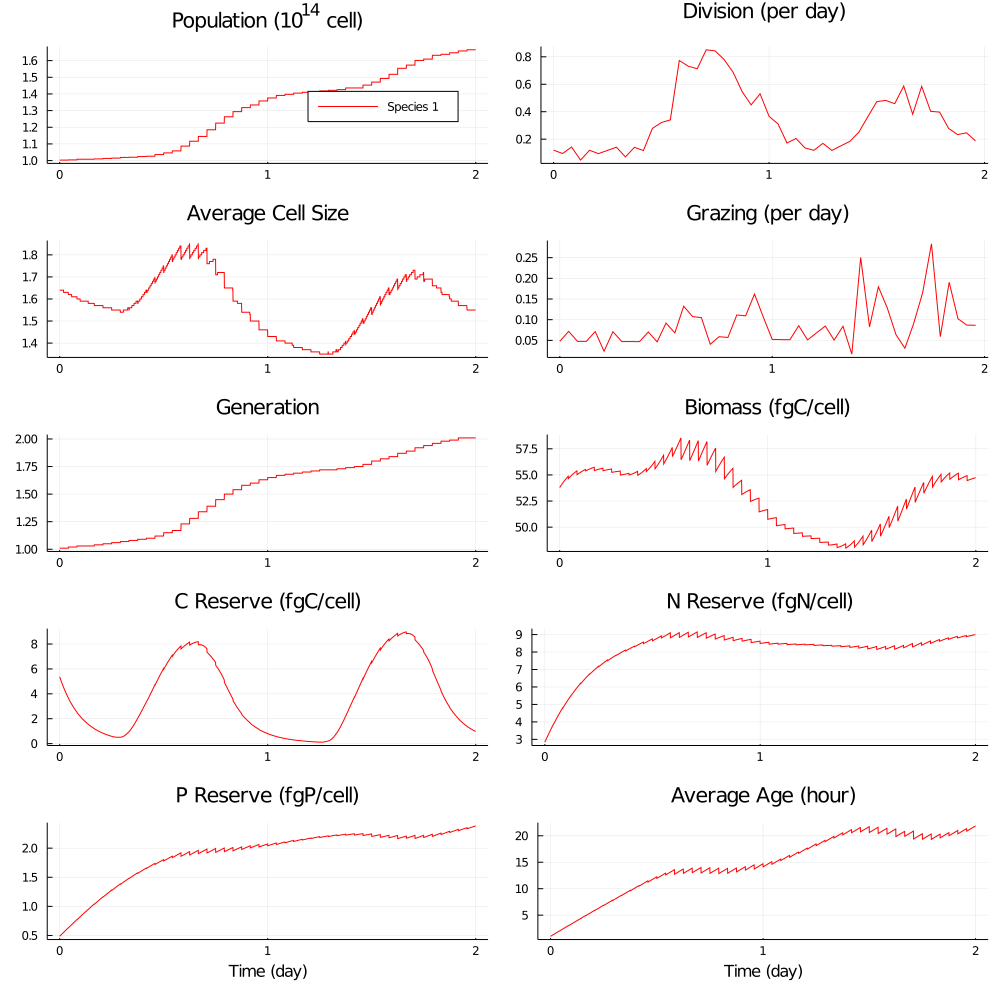

In [21]:
plt

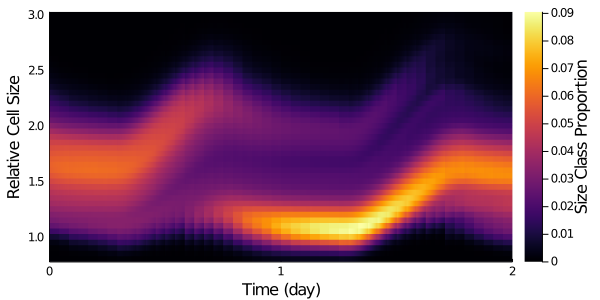

In [19]:
p = heatmap(collect(1:60:86400*nday),collect(0.8:0.05:3),size_dens[:,:,1] ./ 20,
    xticks=([1:3600*24:86400*3;],lbs[1:3]),xlabel="Time (day)",ylabel="Relative Cell Size",
    colorbar_title="Size Class Proportion", size=(600,300))

### for >=2 species, use code below to plot

In [ ]:
p=[]
for i in 1:Nsp
    pt = heatmap(collect(1:60:86400*nday),collect(0.8:0.05:3),size_dens[:,:,i] ./ 20,
        xticks=([1:3600*24:86400*3;],lbs[1:3]),xlabel="Time (day)",ylabel="Relative Cell Size",
        colorbar_title="Size Class Proportion", size=(600,300))
    push!(p,pt)
end
plot(p[1],p[2], layout=(Nsp,1),size=(600,300*Nsp)) # p[3],p[4]...

## Thing to do next...
1. Multiple species with different growth rate etc..
    - Change parameters in `params.yml`
    - `PCmax`: maximum photosynthesis rate
    - `VNO3`, `VNH4`, `VP`: maximum nutrient uptake rates
    - $\alpha$, $\Phi$: light absorption coefficient and maximum quantum yield of photosynthesis
2. 2-Dimensional setup with submesoscale motions
    - Single cell example
    - Heat induced vertical convection
    - Random location of the individual